Sourced from https://m2lines.github.io/L96_demo/notebooks/intro_ML_and_NNs.html

In [1]:
!nvidia-smi

Fri Jan 30 21:06:20 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:25:00.0 Off |                    0 |
| N/A   34C    P0             33W /  250W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
from m_star_predictor import (
    LinearRegression, FCNN, train_model, test_model, fit_model, simple_FCNN, normalize, real_units,
    reduce_dataset, compute_rmse
)
import torch
import torch.utils.data as Data
from torch.utils.data import random_split
from torch import optim
import numpy as np
import os

import matplotlib.pyplot as plt

# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(123);
sklear_random_state = 123

In [3]:
if torch.cuda.is_available():
    print("GPU is available.")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. PyTorch is likely using the CPU.")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

GPU is available.
Number of GPUs: 1
Current GPU name: NVIDIA A100-PCIE-40GB
Using device: cuda


In [2]:
data_directory = '../m_star_dataset'
dataset_name = 'ePBL_paper_expanded_2283_corrected'
dataset_filename = f"{dataset_name}_dataset_M_target.pt"
validation_dataset_filename = f"{dataset_name}_validation_cases.pt"
data = torch.load(os.path.join(data_directory, dataset_filename))
validation_data = torch.load(os.path.join(data_directory, validation_dataset_filename))

In [3]:
X, y = data.T[:,:6].float(), data.T[:,-1].unsqueeze(1).float()
X_val, y_val = validation_data.T[:,:6].float(), validation_data.T[:,-1].unsqueeze(1).float()

In [4]:
X.sqrt()

tensor([[5.0255e-03, 9.9336e-02, 0.0000e+00,        nan, 0.0000e+00, 0.0000e+00],
        [5.0255e-03, 9.9336e-02, 2.2361e+00,        nan, 2.3001e-01,        nan],
        [5.0255e-03, 9.9336e-02, 3.1623e+00,        nan, 2.9548e-01,        nan],
        ...,
        [1.2060e-02, 1.7665e-01, 9.2195e+00, 8.6603e+00, 5.5802e-01,        nan],
        [1.2060e-02, 1.7665e-01, 9.2195e+00, 8.6603e+00, 5.7561e-01,        nan],
        [1.2060e-02, 1.7665e-01, 9.2736e+00, 8.6603e+00, 5.9305e-01,        nan]])

In [9]:
print(X.shape, y.shape)
print(X_val.shape, y_val.shape)

torch.Size([701460, 6]) torch.Size([701460, 1])
torch.Size([701460, 6]) torch.Size([701460, 1])


In [10]:
# reduce dataset if necessary
# Xr, yr = reduce_dataset(X, y)
# X_valr, y_valr = reduce_dataset(X_val, y_val)

In [11]:
# print(Xr.shape, yr.shape)
# print(X_valr.shape, y_valr.shape)

In [12]:
BATCH_SIZE = int(701460 / 8)
print(BATCH_SIZE)

87682


In [13]:
X_mean = X.mean(dim=0)
X_std = X.std(dim=0)
y_mean = y.mean(dim=0)
y_std = y.std(dim=0)

X_train = normalize(data=X, mean=X_mean, std=X_std)
X_test = normalize(data=X_val, mean=X_mean, std=X_std)
y_train = normalize(data=y, mean=y_mean, std=y_std)
y_test = normalize(data=y_val, mean=y_mean, std=y_std)

train_dataset = Data.TensorDataset(X_train, y_train)
test_dataset = Data.TensorDataset(X_test, y_test)

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

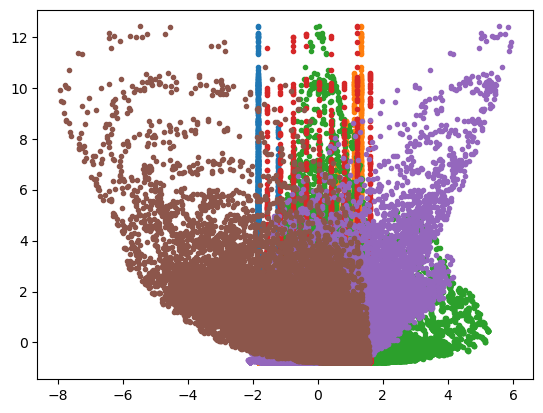

In [14]:
data_iterator = iter(train_loader)
X_iter, subgrid_tend_iter = next(data_iterator)

plt.plot(X_iter, subgrid_tend_iter, '.')

In [15]:
linear_network = LinearRegression(input_size=6)
fcnn_network = FCNN(input_size=6)

In [16]:
loss_fn = torch.nn.MSELoss()

In [17]:
# Load the input and output pair from the data loader
X_tmp = next(iter(train_loader))

# Predict the output
y_tmp_linear = linear_network(torch.unsqueeze(X_tmp[0], 1))
y_tmp_fcnn = fcnn_network(torch.unsqueeze(X_tmp[0], 1))

# Calculate the MSE loss
loss_linear = loss_fn(y_tmp_linear, torch.unsqueeze(X_tmp[1], 1))
print(f"Linear network MSE Loss: {loss_linear.item()}")

loss_fcnn = loss_fn(y_tmp_fcnn, torch.unsqueeze(X_tmp[1], 1))
print(f"FCNN MSE Loss: {loss_fcnn.item()}")

Linear network MSE Loss: 1.4616767168045044
FCNN MSE Loss: 1.1232552528381348


In [18]:
learning_rate = 0.003
momentum = 0.1
weight_decay = 1e-3

In [19]:
optimizer_linear = optim.Adam(
    linear_network.parameters(), lr=learning_rate, weight_decay=weight_decay
)
optimizer_fcnn = optim.Adam(
    fcnn_network.parameters(), lr=learning_rate, weight_decay=weight_decay
)

In [20]:
n_epochs_linear = 100
n_epochs_fcnn = 100

In [21]:
# fcnn_network = fcnn_network.to(device)
# linear_network = linear_network.to(device)

In [22]:
train_loss_linear, test_loss_linear = fit_model(
    linear_network, loss_fn, optimizer_linear, train_loader, test_loader, n_epochs_linear, device
)

epoch 1 completed
epoch 2 completed
epoch 3 completed
epoch 4 completed
epoch 5 completed
epoch 6 completed
epoch 7 completed
epoch 8 completed
epoch 9 completed
epoch 10 completed
epoch 11 completed
epoch 12 completed
epoch 13 completed
epoch 14 completed
epoch 15 completed
epoch 16 completed
epoch 17 completed
epoch 18 completed
epoch 19 completed
epoch 20 completed
epoch 21 completed
epoch 22 completed
epoch 23 completed
epoch 24 completed
epoch 25 completed
epoch 26 completed
epoch 27 completed
epoch 28 completed
epoch 29 completed
epoch 30 completed
epoch 31 completed
epoch 32 completed
epoch 33 completed
epoch 34 completed
epoch 35 completed
epoch 36 completed
epoch 37 completed
epoch 38 completed
epoch 39 completed
epoch 40 completed
epoch 41 completed
epoch 42 completed
epoch 43 completed
epoch 44 completed
epoch 45 completed
epoch 46 completed
epoch 47 completed
epoch 48 completed
epoch 49 completed
epoch 50 completed
epoch 51 completed
epoch 52 completed
epoch 53 completed
ep

In [24]:
train_loss_fcnn, test_loss_fcnn = fit_model(
    fcnn_network, loss_fn, optimizer_fcnn, train_loader, test_loader, n_epochs_fcnn, device
)

epoch 1 completed
epoch 2 completed
epoch 3 completed
epoch 4 completed
epoch 5 completed
epoch 6 completed
epoch 7 completed
epoch 8 completed
epoch 9 completed
epoch 10 completed
epoch 11 completed
epoch 12 completed
epoch 13 completed
epoch 14 completed
epoch 15 completed
epoch 16 completed
epoch 17 completed
epoch 18 completed
epoch 19 completed
epoch 20 completed
epoch 21 completed
epoch 22 completed
epoch 23 completed
epoch 24 completed
epoch 25 completed
epoch 26 completed
epoch 27 completed
epoch 28 completed
epoch 29 completed
epoch 30 completed
epoch 31 completed
epoch 32 completed
epoch 33 completed
epoch 34 completed
epoch 35 completed
epoch 36 completed
epoch 37 completed
epoch 38 completed
epoch 39 completed
epoch 40 completed
epoch 41 completed
epoch 42 completed
epoch 43 completed
epoch 44 completed
epoch 45 completed
epoch 46 completed
epoch 47 completed
epoch 48 completed
epoch 49 completed
epoch 50 completed
epoch 51 completed
epoch 52 completed
epoch 53 completed
ep

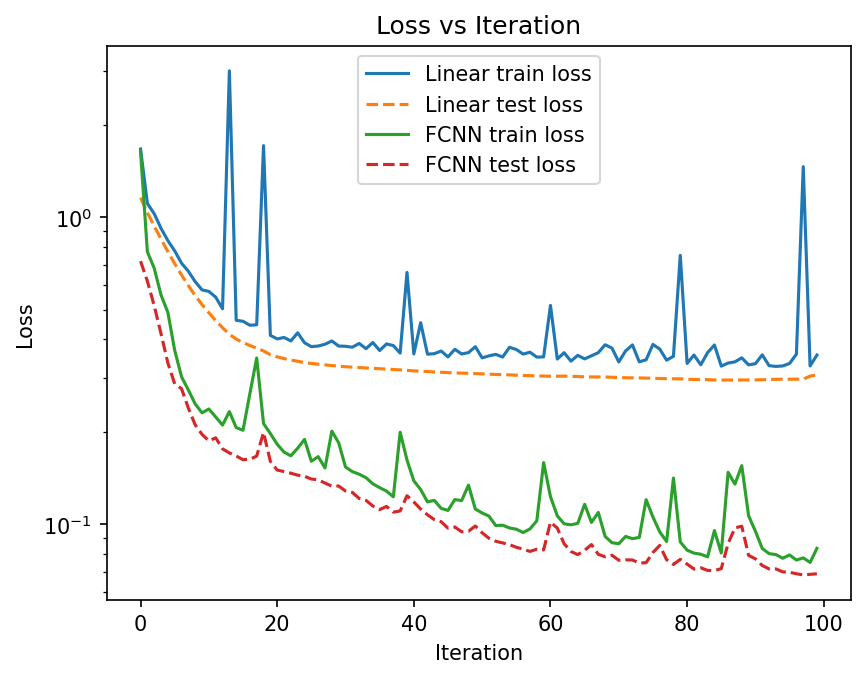

In [25]:
plt.figure(dpi=150)

plt.plot(train_loss_linear, label="Linear train loss")
plt.plot(test_loss_linear, linestyle="--", label="Linear test loss")

plt.plot(train_loss_fcnn, label="FCNN train loss")
plt.plot(test_loss_fcnn, linestyle="--", label="FCNN test loss")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.show();

In [39]:
X_normalized = normalize(data=X, mean=X_mean, std=X_std).to(device)
fcnn_prediction_full = real_units(normalized_data=fcnn_network(X_normalized).cpu(), mean=y_mean, std=y_std)
linear_prediction_full = real_units(normalized_data=linear_network(X_normalized).cpu(), mean=y_mean, std=y_std)

X_val_normalized = normalize(data=X_val, mean=X_mean, std=X_std).to(device)
fcnn_val_prediction_full = real_units(normalized_data=fcnn_network(X_val_normalized).cpu(), mean=y_mean, std=y_std)
linear_val_prediction_full = real_units(normalized_data=linear_network(X_val_normalized).cpu(), mean=y_mean, std=y_std)

fcnn_prediction_train_set = real_units(normalized_data=fcnn_network(X_train.to(device)).cpu(), mean=y_mean, std=y_std)
linear_prediction_train_set = real_units(normalized_data=linear_network(X_train.to(device)).cpu(), mean=y_mean, std=y_std)
fcnn_prediction_test_set = real_units(normalized_data=fcnn_network(X_test.to(device)).cpu(), mean=y_mean, std=y_std)
linear_prediction_test_set = real_units(normalized_data=linear_network(X_test.to(device)).cpu(), mean=y_mean, std=y_std)

Text(0.5, 0, '$M_{pred}$')

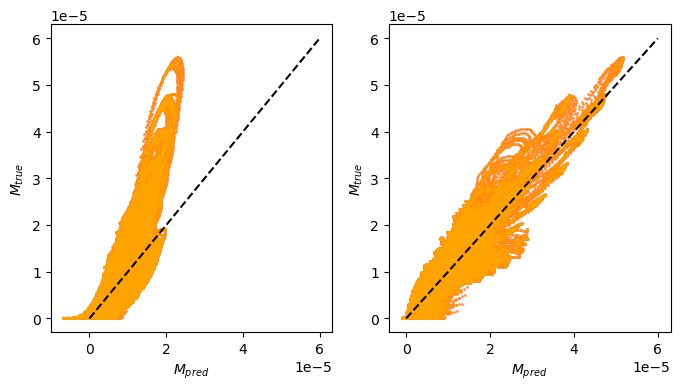

In [41]:
xs, ys = np.linspace(0., 6e-5, 1000), np.linspace(0., 6e-5, 1000)

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(linear_prediction_full.detach().numpy(), y, color="red", s=1, alpha=.4)
ax[0].scatter(linear_prediction_train_set.detach().numpy(), y, color="orange", s=1, alpha=.4)
ax[0].plot(xs, ys, color="black", linestyle="dashed")
ax[0].set_ylabel("$M_{true}$")
ax[0].set_xlabel("$M_{pred}$")

ax[1].scatter(fcnn_prediction_full.detach().numpy(), y, color="red", s=1, alpha=.4)
ax[1].scatter(fcnn_prediction_train_set.detach().numpy(), y, color="orange", s=1, alpha=.4)
ax[1].plot(xs, ys, color="black", linestyle="dashed")
ax[1].set_ylabel("$M_{true}$")
ax[1].set_xlabel("$M_{pred}$")

# plt.savefig("inst_M_true_pred_with_utau.png", dpi=300)

Text(0.5, 0, '$M_{pred}$')

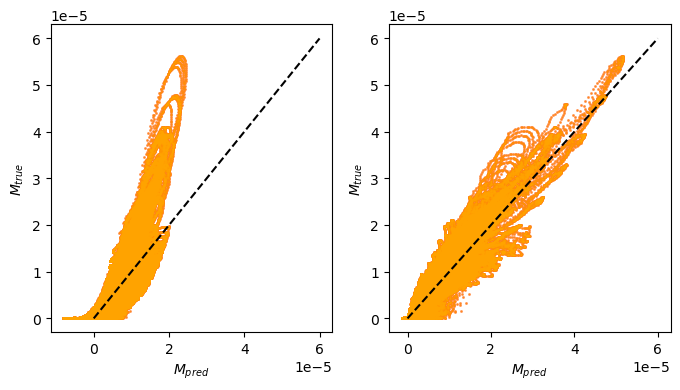

In [42]:
xs, ys = np.linspace(0., 6e-5, 1000), np.linspace(0., 6e-5, 1000)

fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(linear_val_prediction_full.detach().numpy(), y_val, color="red", s=1, alpha=.4)
ax[0].scatter(linear_prediction_test_set.detach().numpy(), y_val, color="orange", s=1, alpha=.4)
ax[0].plot(xs, ys, color="black", linestyle="dashed")
ax[0].set_ylabel("$M_{true}$")
ax[0].set_xlabel("$M_{pred}$")

ax[1].scatter(fcnn_val_prediction_full.detach().numpy(), y_val, color="red", s=1, alpha=.4)
ax[1].scatter(fcnn_prediction_test_set.detach().numpy(), y_val, color="orange", s=1, alpha=.4)
ax[1].plot(xs, ys, color="black", linestyle="dashed")
ax[1].set_ylabel("$M_{true}$")
ax[1].set_xlabel("$M_{pred}$")

In [52]:
9 * 24 * 2

432

In [30]:
import json

with open(os.path.join(data_directory, f'{dataset_name}_training_set_dropped_cases.json'), 'r') as file:
    gotm_dropped_case_dict = json.load(file)

In [31]:
cases_to_drop = np.load(os.path.join(data_directory, f'{dataset_name}_dropped_cases.npy'))

/tmp/ipykernel_3021669/3812061061.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(tight_layout=True)


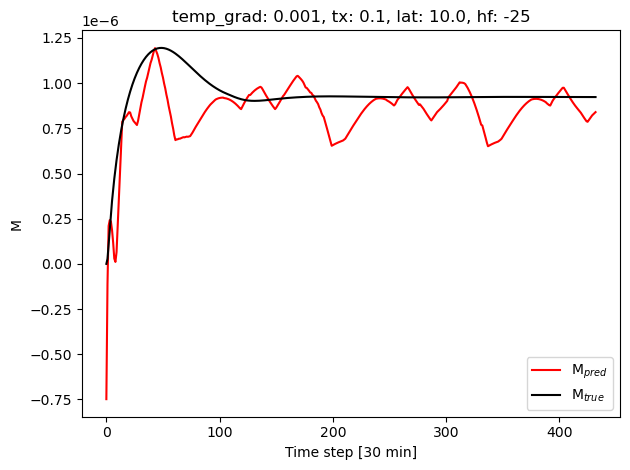

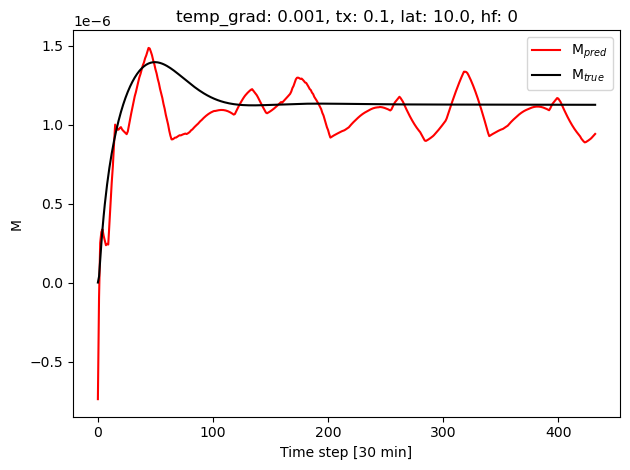

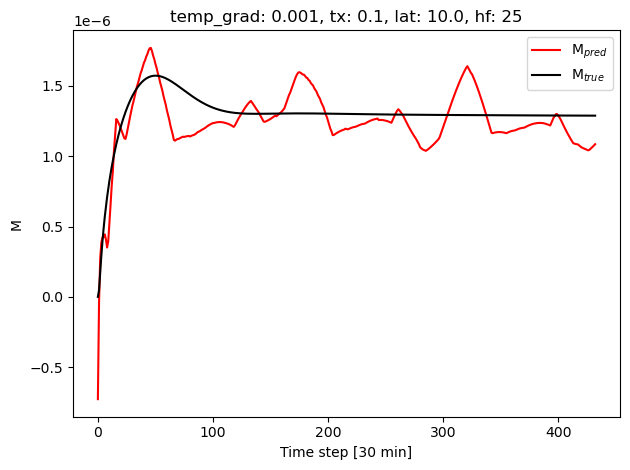

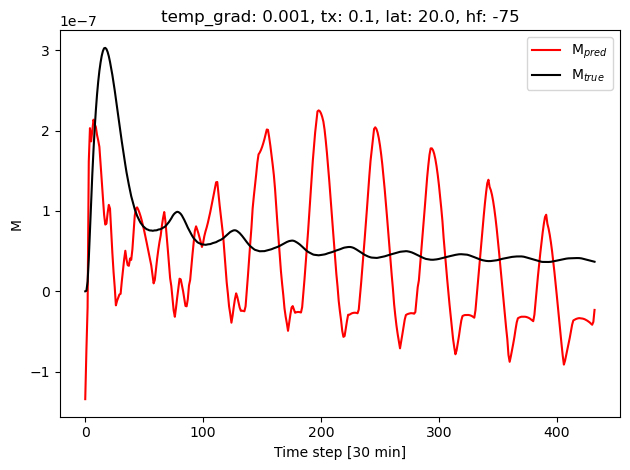

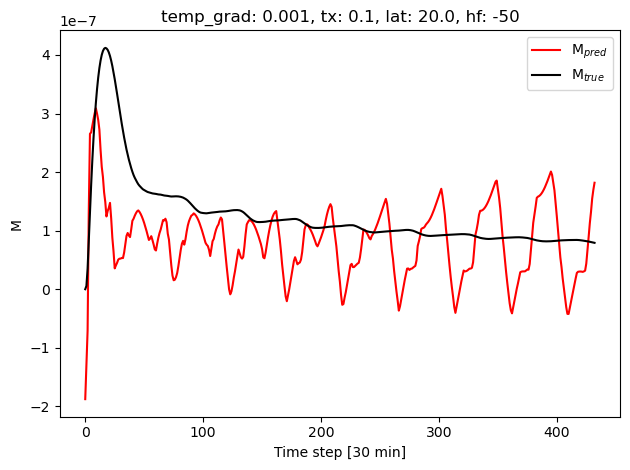

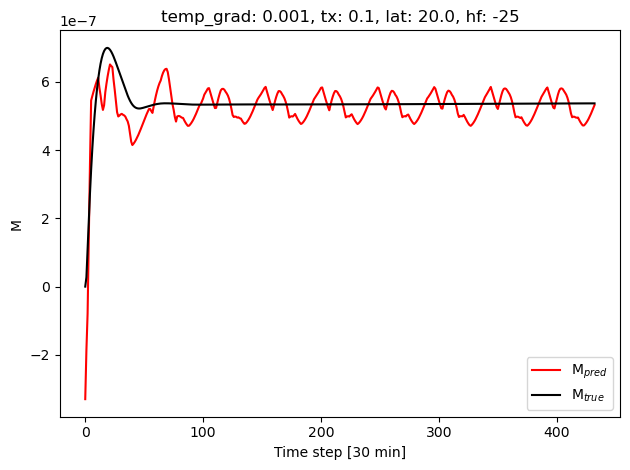

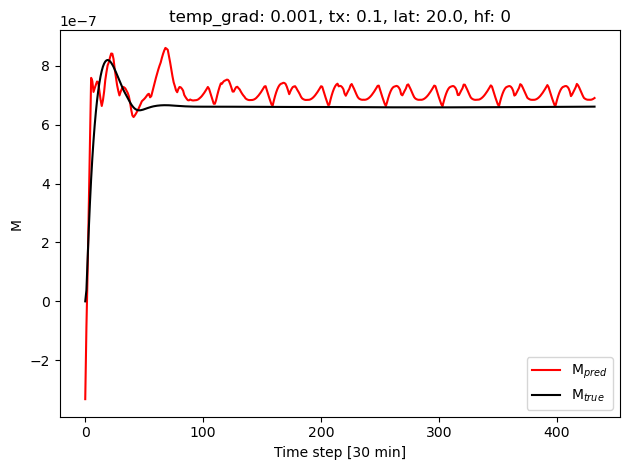

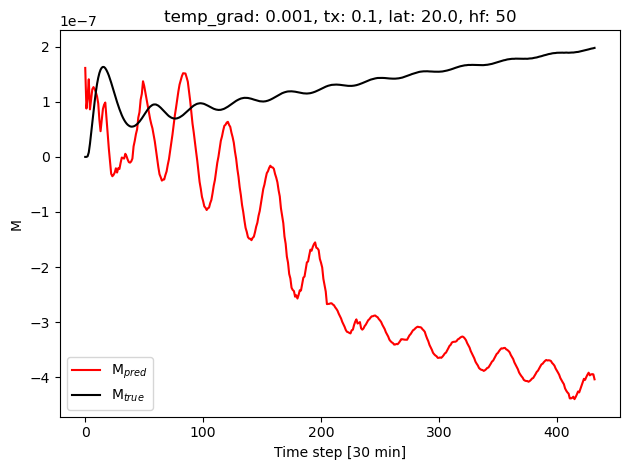

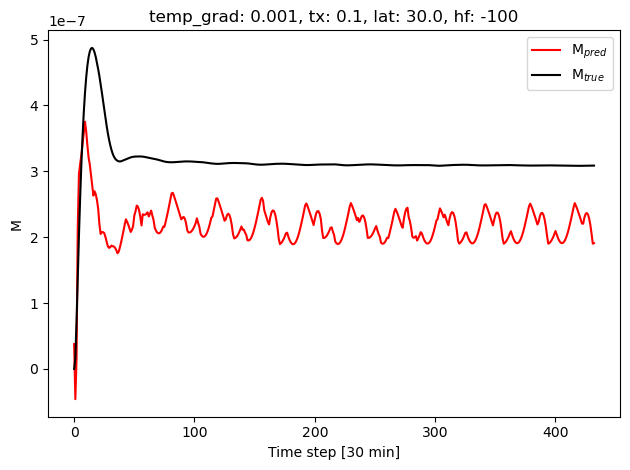

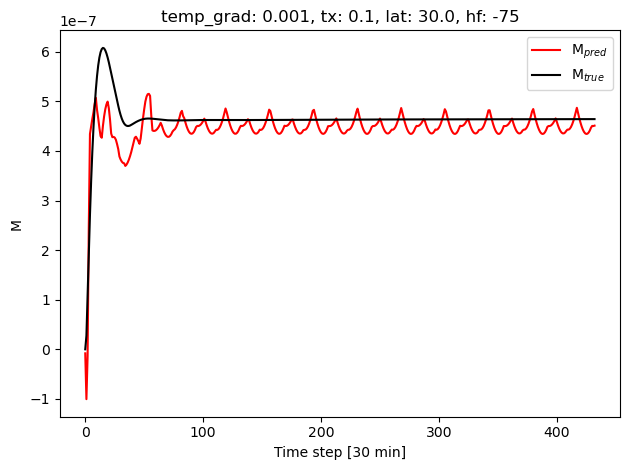

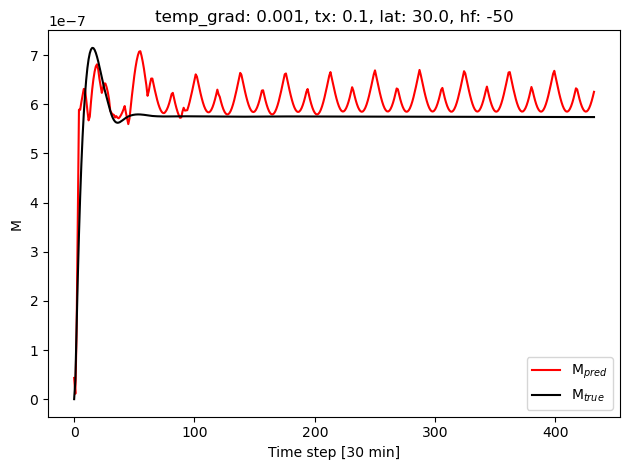

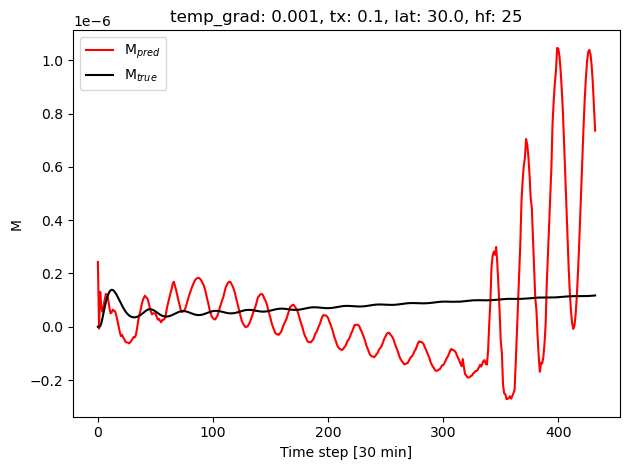

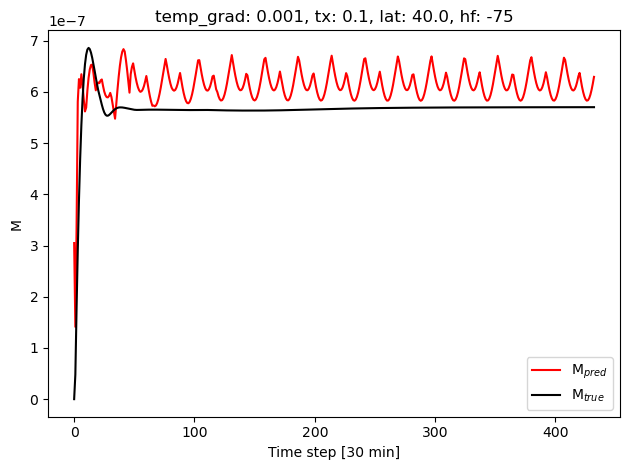

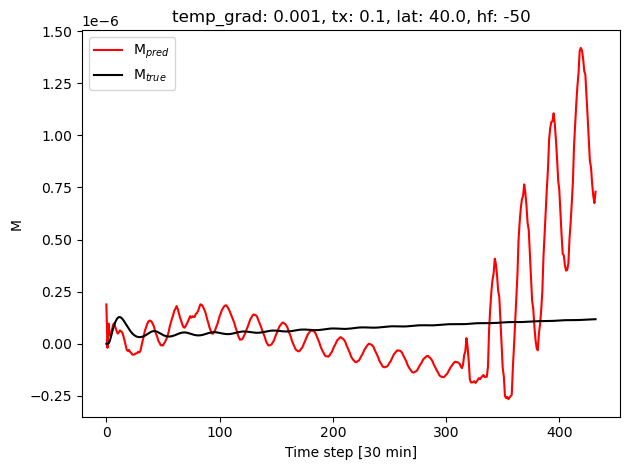

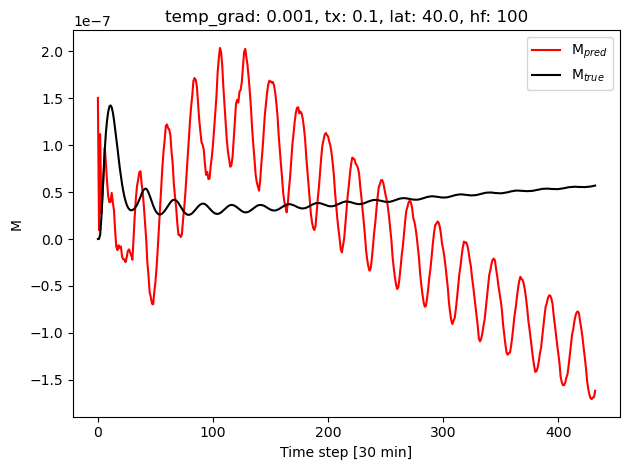

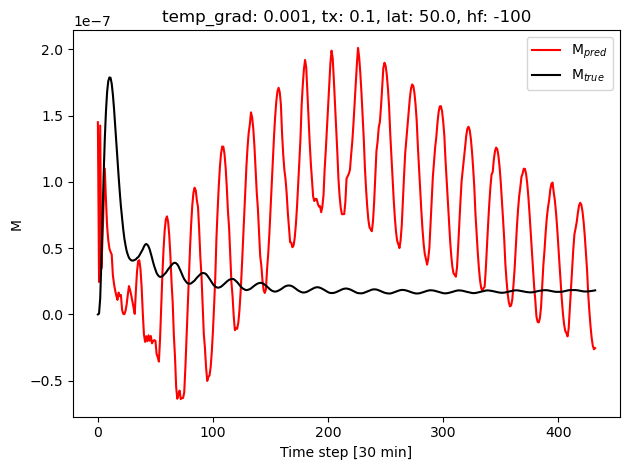

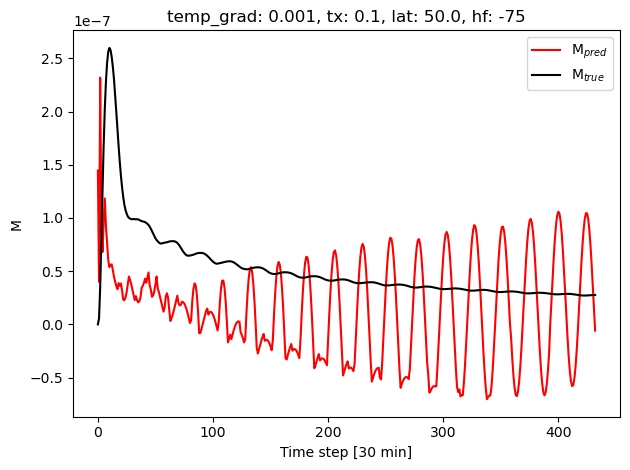

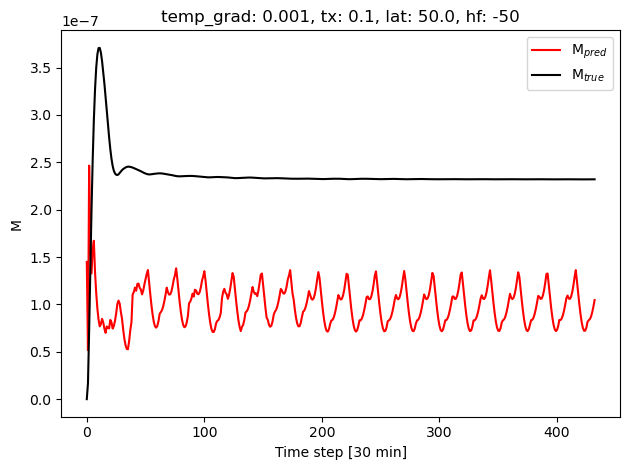

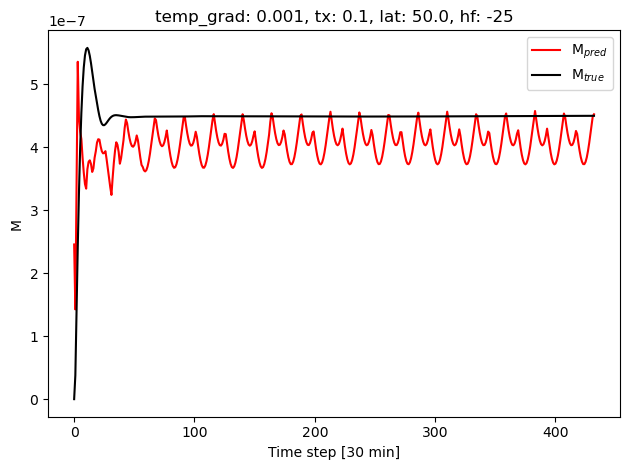

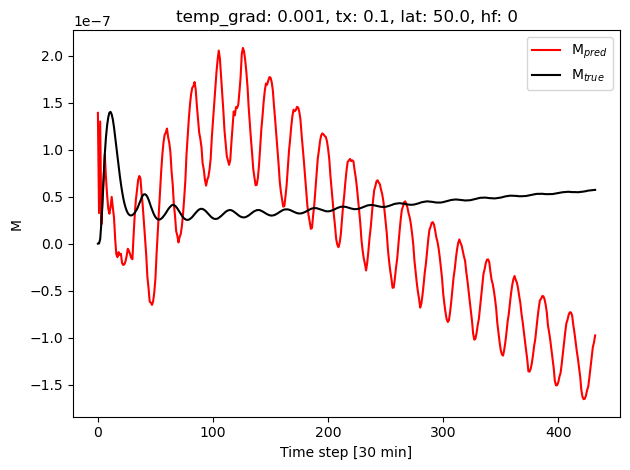

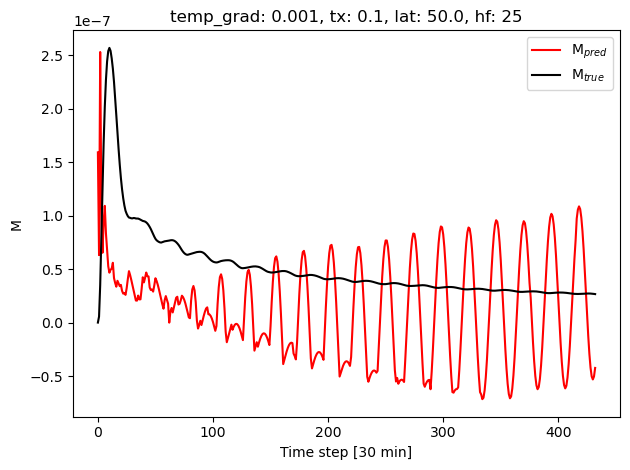

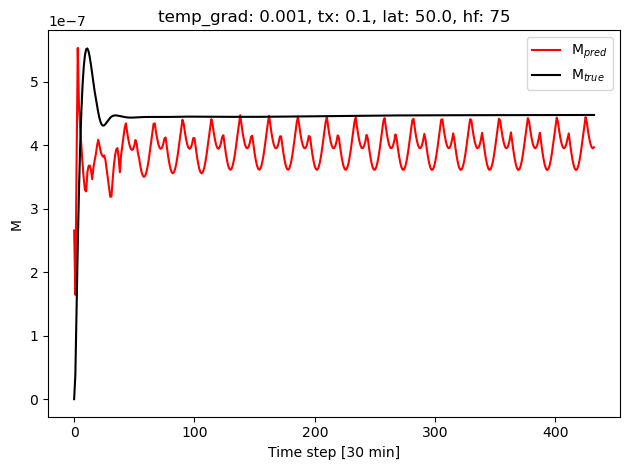

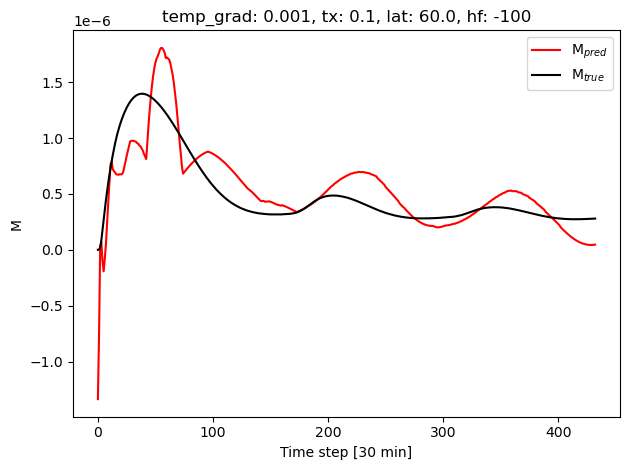

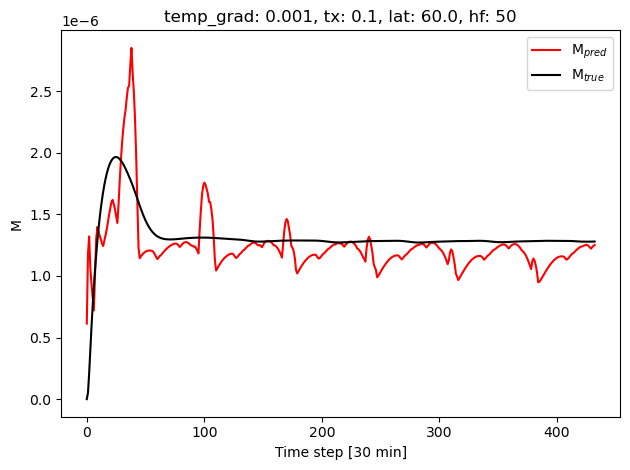

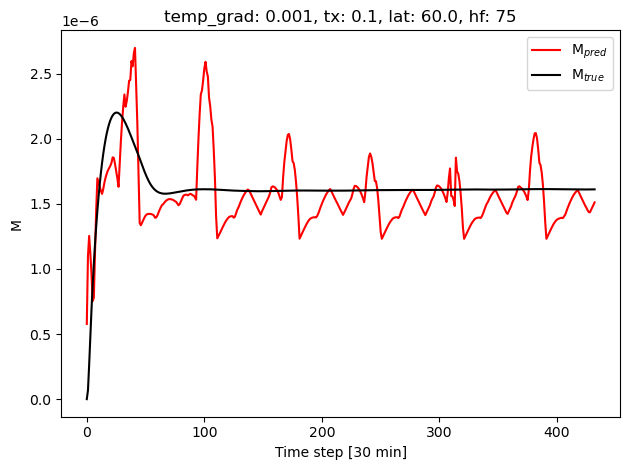

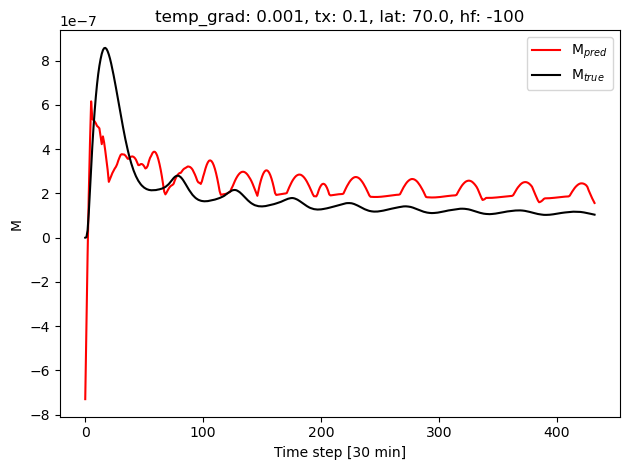

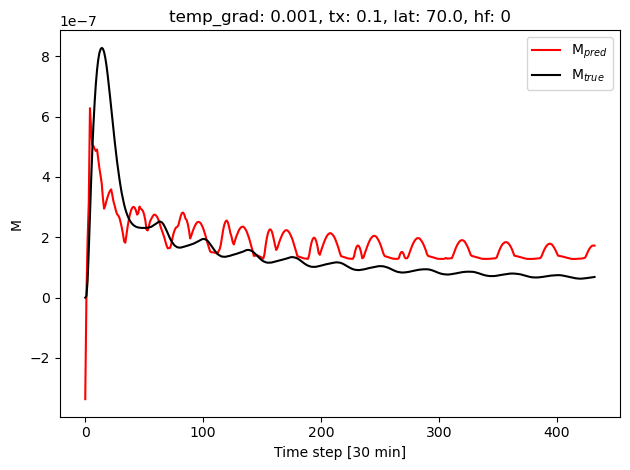

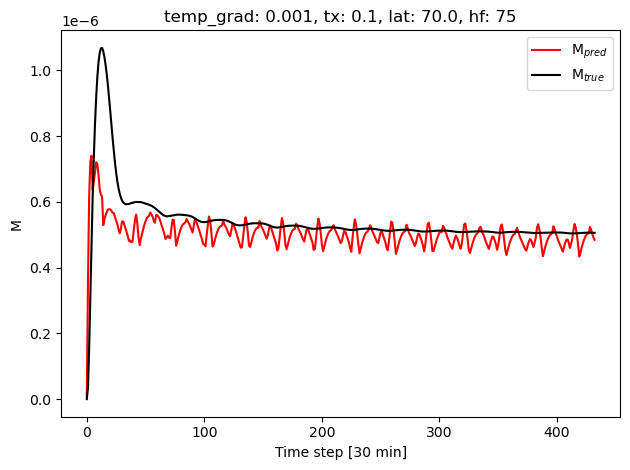

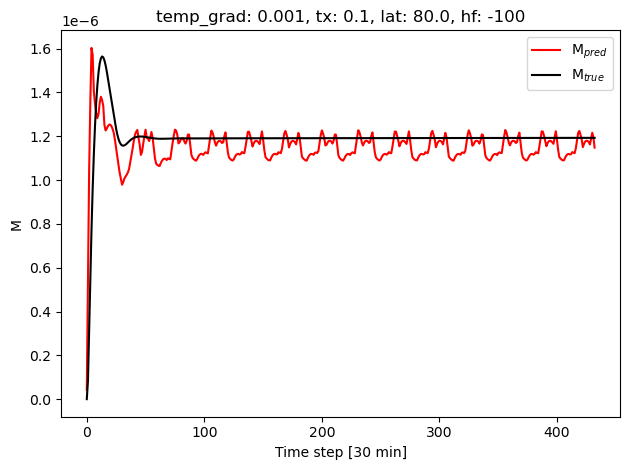

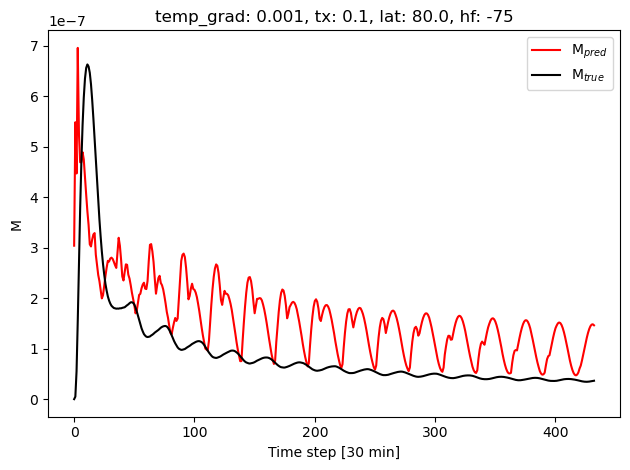

In [32]:
for i in cases_to_drop[:30]:
    case_specs = gotm_dropped_case_dict[f"case_{i+1}"]
    tg, tx, lat, hf = case_specs['temp_grad'], case_specs['tx'], case_specs['lat'], case_specs['heat_flux']
    plt.figure(tight_layout=True)
    plt.title(f"temp_grad: {tg}, tx: {tx}, lat: {lat}, hf: {hf}")
    plt.plot(fcnn_prediction_full.detach().numpy()[433*i:433*(i+1)], label="M$_{pred}$", color="red")
    plt.plot(y[433*i:433*(i+1)], label="M$_{true}$", color="black")
    plt.xlabel("Time step [30 min]")
    plt.ylabel("M")
    plt.legend()

/tmp/ipykernel_3021669/850567976.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(tight_layout=True)


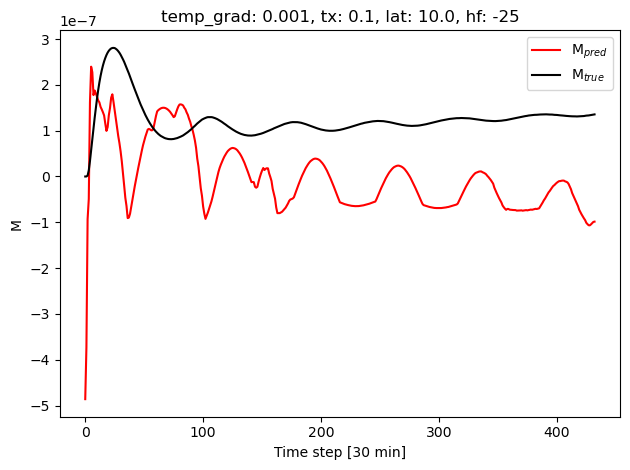

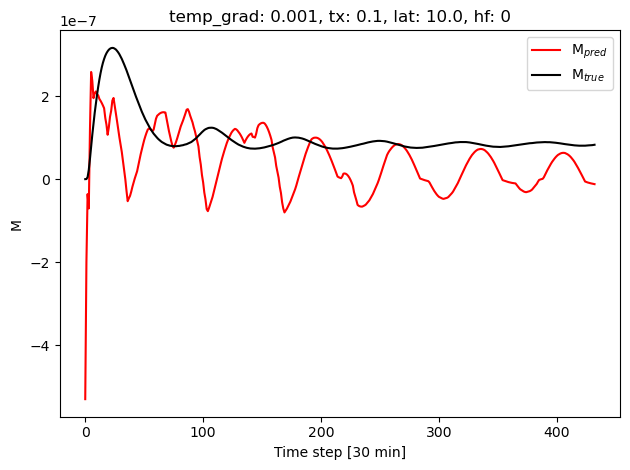

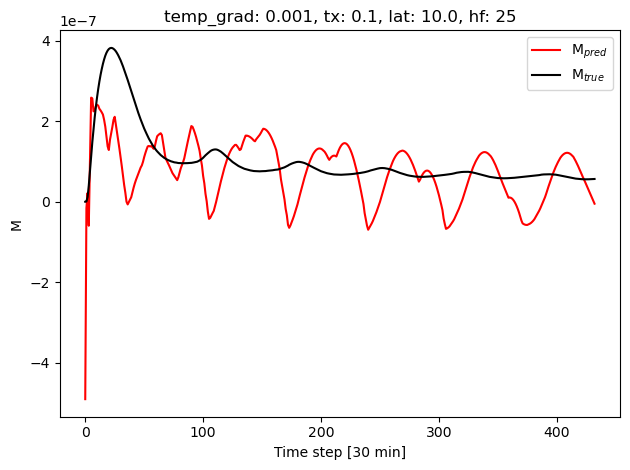

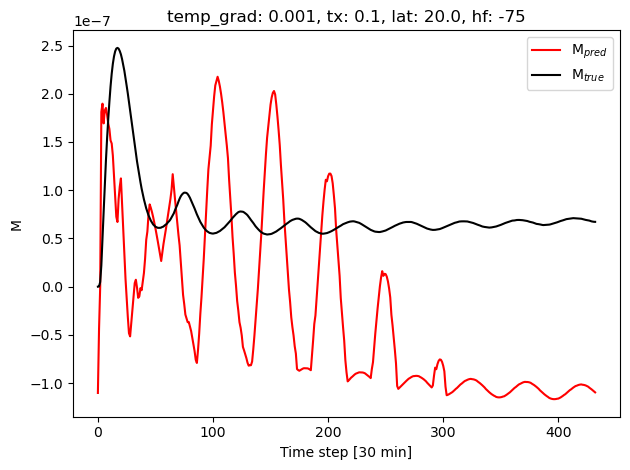

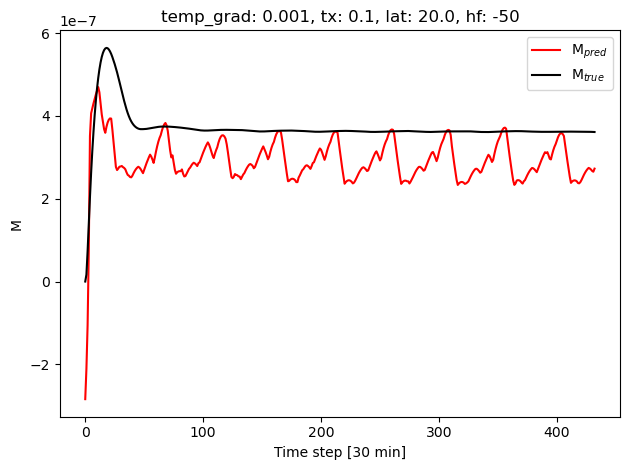

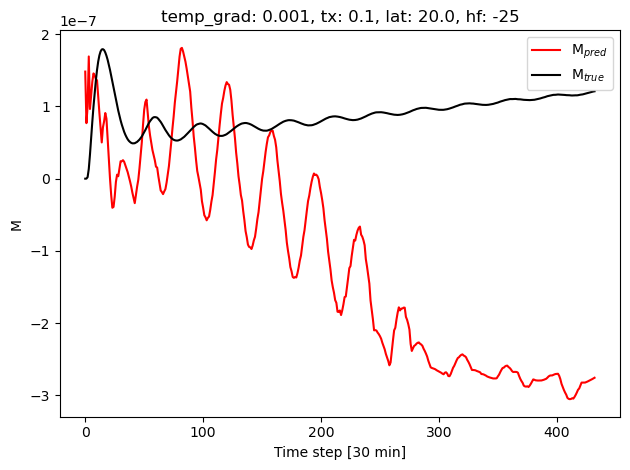

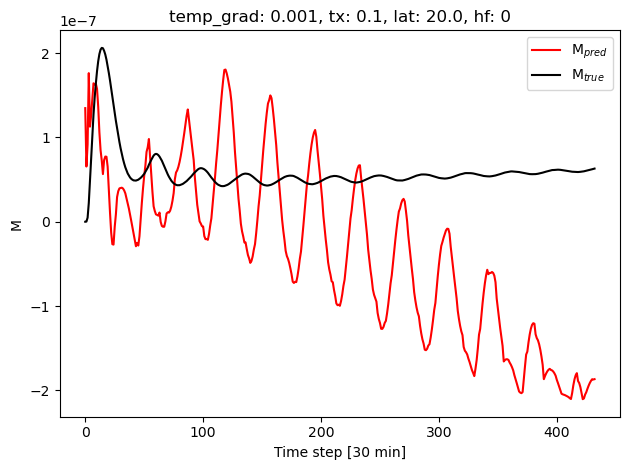

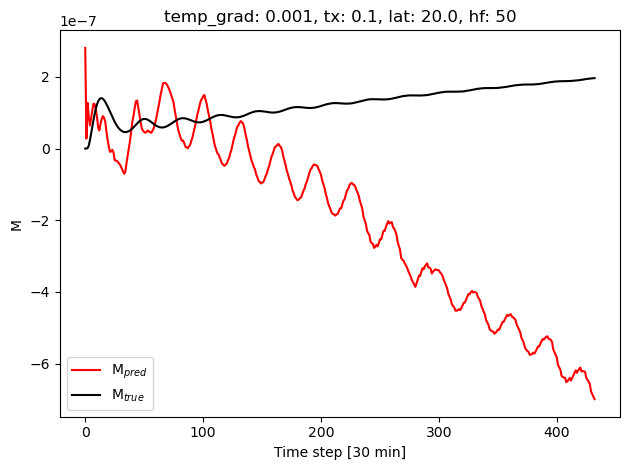

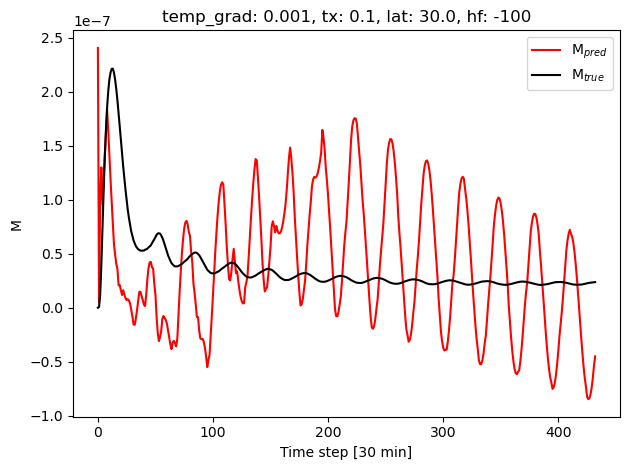

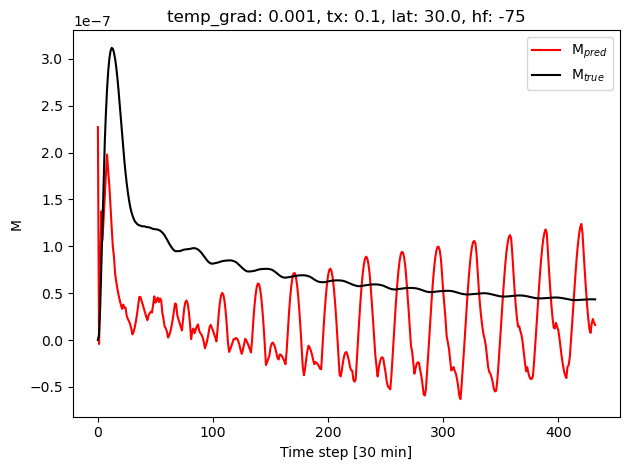

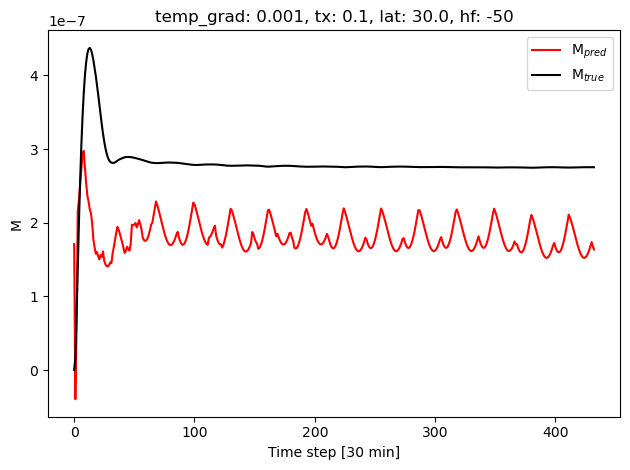

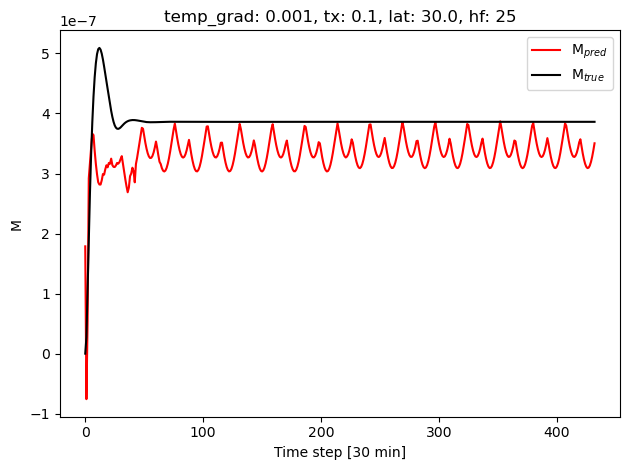

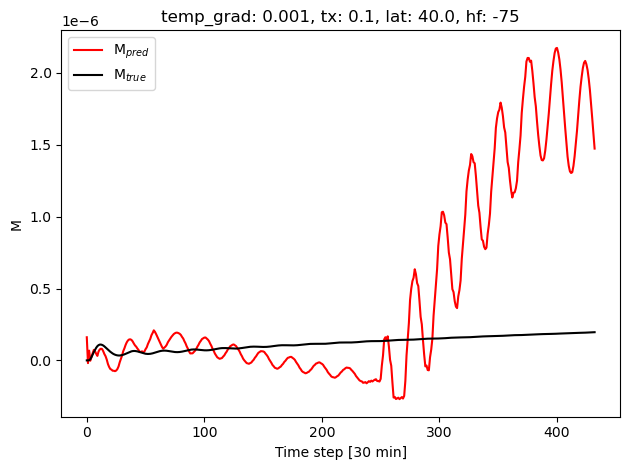

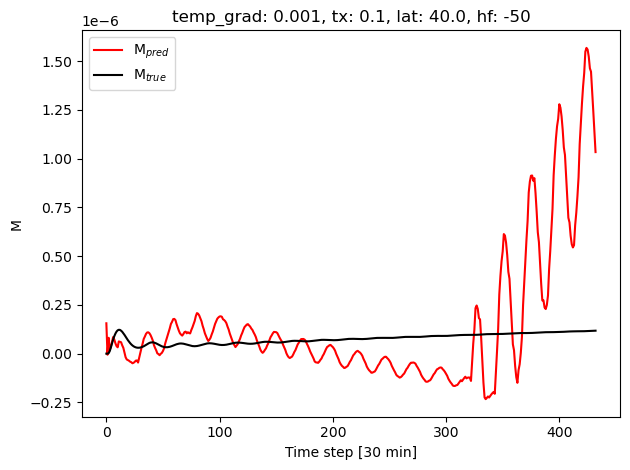

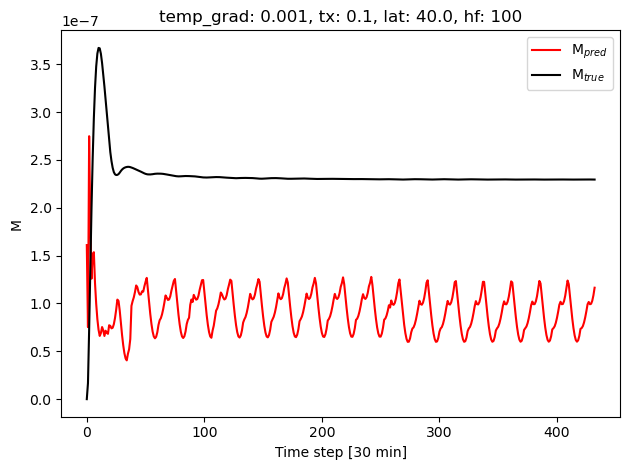

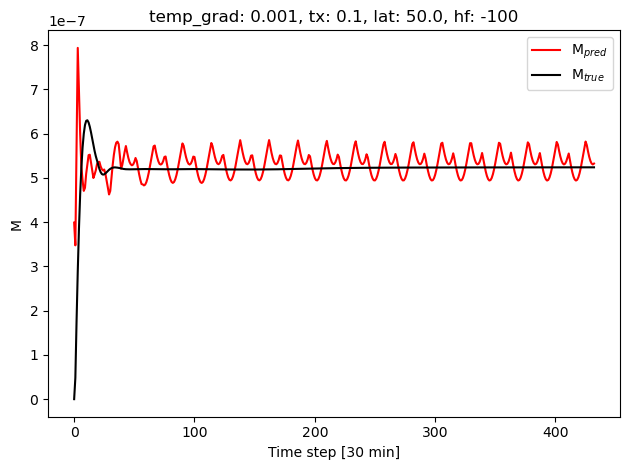

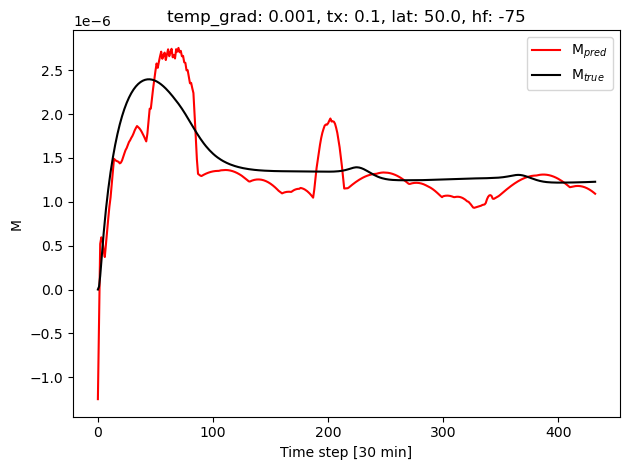

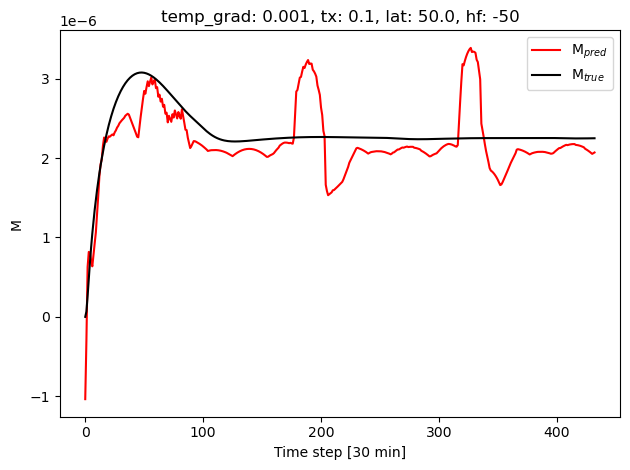

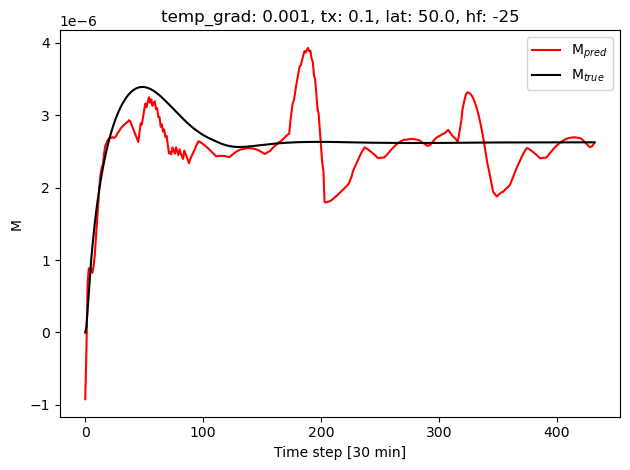

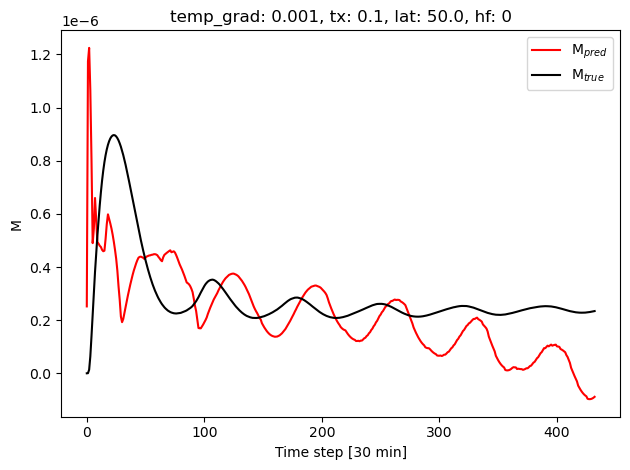

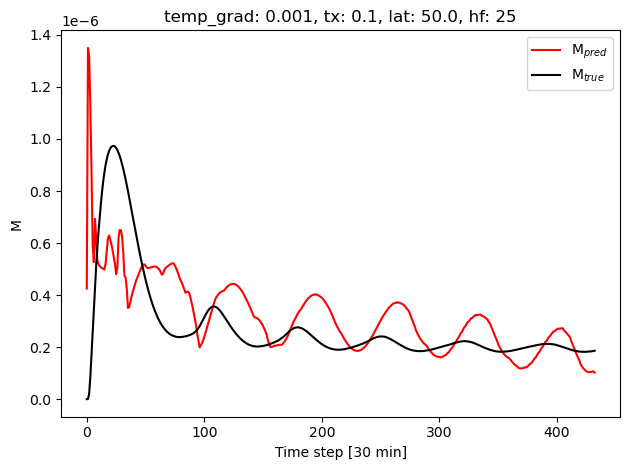

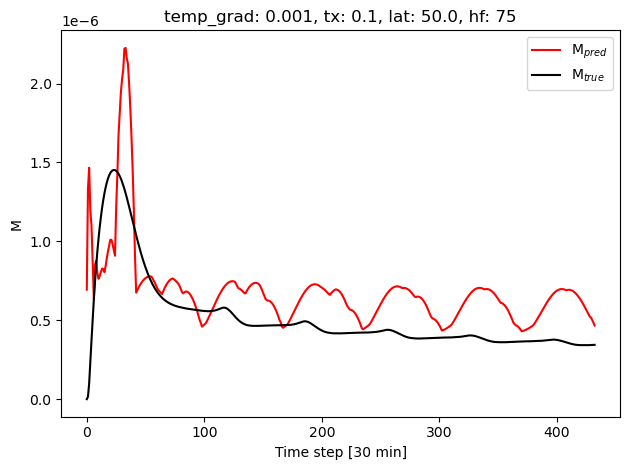

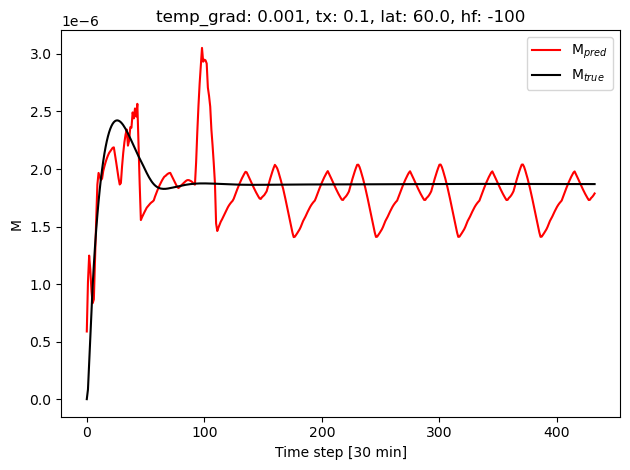

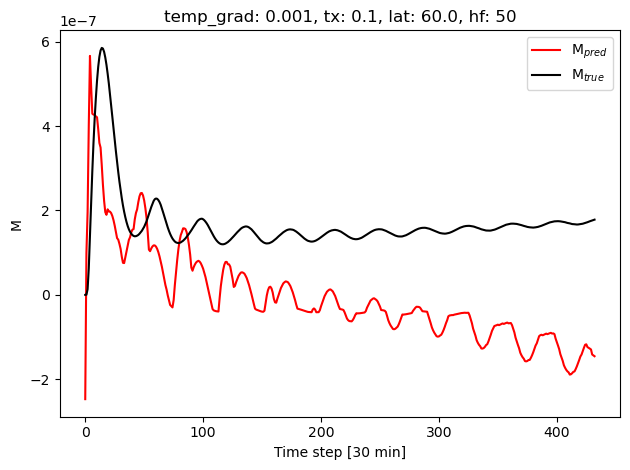

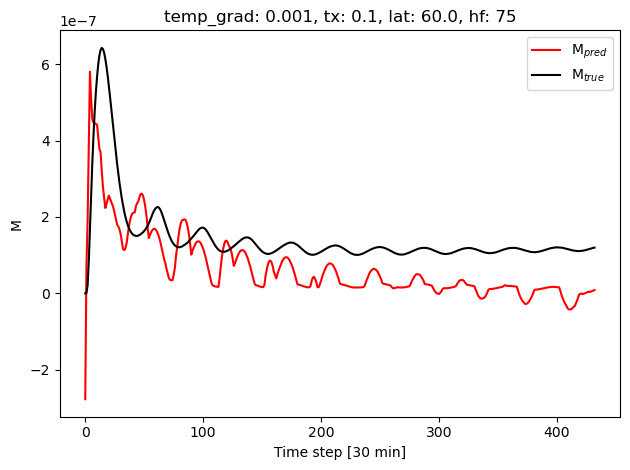

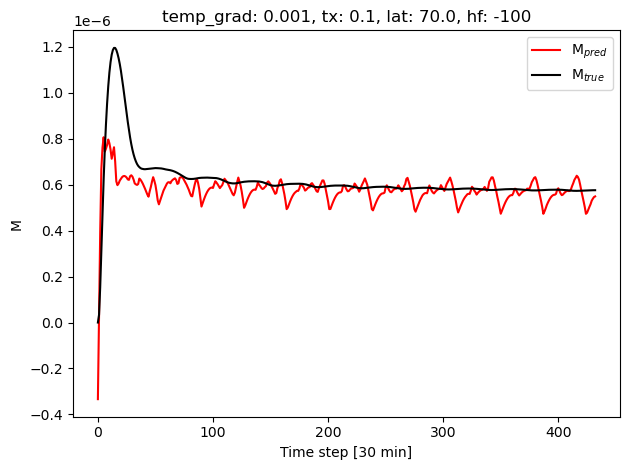

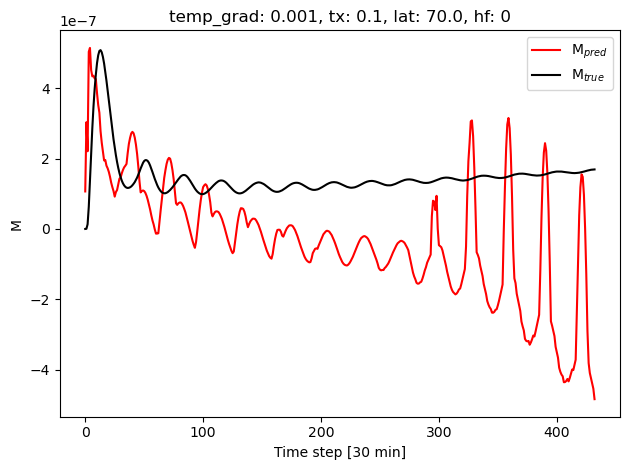

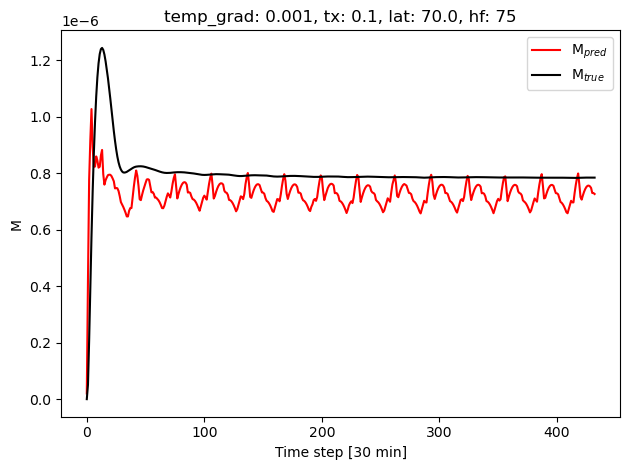

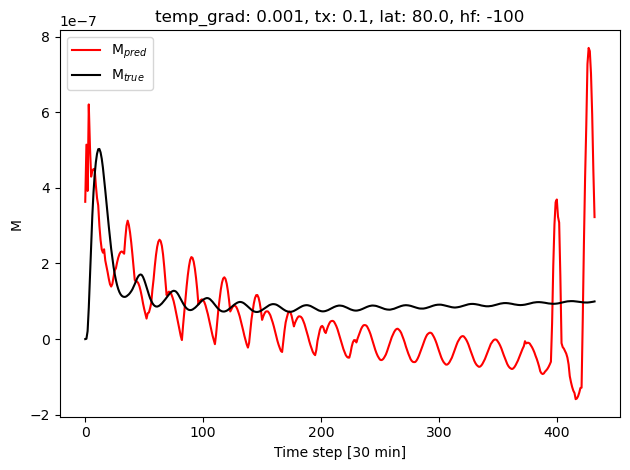

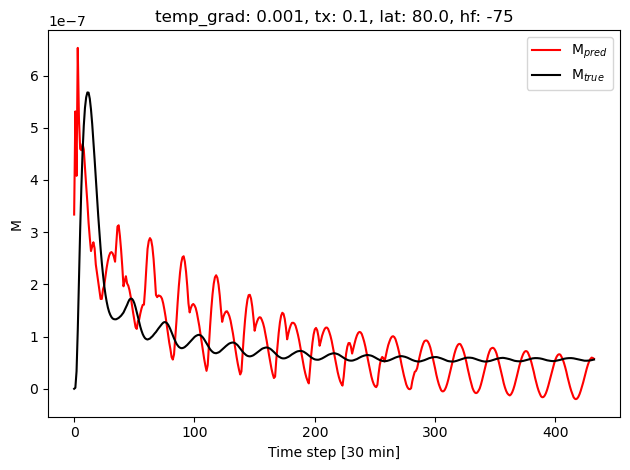

In [33]:
for i in cases_to_drop[:30]:
    case_specs = gotm_dropped_case_dict[f"case_{i+1}"]
    tg, tx, lat, hf = case_specs['temp_grad'], case_specs['tx'], case_specs['lat'], case_specs['heat_flux']
    plt.figure(tight_layout=True)
    plt.title(f"temp_grad: {tg}, tx: {tx}, lat: {lat}, hf: {hf}")
    plt.plot(fcnn_val_prediction_full.detach().numpy()[433*i:433*(i+1)], label="M$_{pred}$", color="red")
    plt.plot(y_val[433*i:433*(i+1)], label="M$_{true}$", color="black")
    plt.xlabel("Time step [30 min]")
    plt.ylabel("M")
    plt.legend()

In [34]:
compute_rmse(y_pred=linear_prediction_full.detach().numpy(), y_true=y.detach().numpy())

0.0018232454

In [35]:
compute_rmse(y_pred=fcnn_prediction_full.detach().numpy(), y_true=y.detach().numpy())

0.0018406049

In [36]:
compute_rmse(y_pred=fcnn_val_prediction_full.detach().numpy(), y_true=y_val.detach().numpy())

0.0018095465

In [37]:
compute_rmse(y_pred=linear_val_prediction_full.detach().numpy(), y_true=y_val.detach().numpy())

0.0017815677